In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

plt.style.use("ggplot")

In [178]:
img = cv2.imread("../data/download_image_monthly/20171024/full/7ea5ecd63f7fa6627a6ba95559f5e288bbe45d40.jpg")
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb = cv2.resize(img_rgb, (img.shape[1]//10, img.shape[0]//10))

(-0.5, 55.5, 79.5, -0.5)

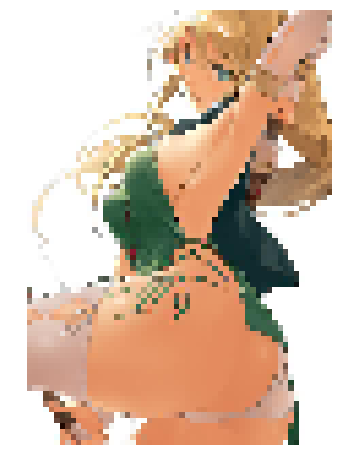

In [179]:
plt.figure(figsize=(12,8))
plt.imshow(img_rgb)
plt.axis("off")

RGBそれぞれについてcountをするために、画像を崩して前処理

In [5]:
c_data = img_hsv.reshape(-1, 3)

In [6]:
df = pd.DataFrame(c_data, columns=["Hue", "Saturation", "Value"])

HSV分析

SOMをつかって似た色をまとめた画像を作っていく

### 自己組織化マップ

In [180]:
class SOM():

    def __init__(self, teachers, N, seed=None):
        self.teachers = np.array(teachers).reshape(-1,3)
        self.n_teacher = self.teachers.shape[0] * self.teachers.shape[1]
        self.w = self.teachers.shape[0]
        self.h = self.teachers.shape[1]
        self.N = N
        if not seed is None:
            np.random.seed(seed)

        x, y = np.meshgrid(range(self.w), range(self.h))
        self.c = np.hstack((y.flatten()[:, np.newaxis],
                            x.flatten()[:, np.newaxis]))
        self.nodes = np.random.rand(self.w,self.h)
        print(self.nodes.shape)

    def train(self):
        for i, teacher in enumerate(self.teachers):
            bmu = self._best_matching_unit(teacher)
            d = np.linalg.norm(self.c - bmu, axis=1)
            L = self._learning_ratio(i)
            S = self._learning_radius(i, d)
            self.nodes += L * S.reshape(-1,3) * (teacher - self.nodes)
            #self.nodes += L * S[:, np.newaxis] * (teacher - self.nodes)
        
        return self.nodes

    def _best_matching_unit(self, teacher):
        #compute all norms (square)
        norms = np.linalg.norm(self.nodes - teacher, axis=1)
        bmu = np.argmin(norms) #argment with minimum element 
        return np.unravel_index(bmu,(self.w, self.h))

    def _neighbourhood(self, t):#neighbourhood radious
        halflife = float(self.n_teacher/4) #for testing
        initial  = float(self.N/2)
        return initial*np.exp(-t/halflife)

    def _learning_ratio(self, t):
        halflife = float(self.n_teacher/4) #for testing
        initial  = 0.1
        return initial*np.exp(-t/halflife)

    def _learning_radius(self, t, d):
        # d is distance from BMU
        s = self._neighbourhood(t)
        return np.exp(-d**2/(2*s**2))

In [211]:
class SOM():
    def __init__(self, teachers, N, seed=None):
        self.teachers = np.array(teachers).reshape(-1,3)
        self.n_teacher = self.teachers.shape[0]
        self.N = N
        if not seed is None:
            np.random.seed(seed)
            
        x, y = np.meshgrid(range(self.N), range(self.N))
        self.c = np.hstack((x.flatten()[:, np.newaxis],
                            y.flatten()[:, np.newaxis]))
        self.nodes = np.random.rand(self.N*self.N,
                                    self.teachers.shape[1])
    
    def train(self):
        for i, teacher in enumerate(self.teachers):
            bmu = self._best_matching_unit(teacher)
            d = np.linalg.norm(self.c - bmu, axis=1)
            L = self._learning_ratio(i)
            S = self._learning_radius(i, d)
            self.nodes += L * S[:, np.newaxis] * (teacher - self.nodes)
        return self.nodes

    def _best_matching_unit(self, teacher):
        #compute all norms (square)
        norms = np.linalg.norm(self.nodes - teacher, axis=1)
        bmu = np.argmin(norms) #argment with minimum element 
        return np.unravel_index(bmu,(self.N, self.N))

    def _neighbourhood(self, t):#neighbourhood radious
        halflife = float(self.n_teacher/4) #for testing
        initial  = float(self.N/2)
        return initial*np.exp(-t/halflife)

    def _learning_ratio(self, t):
        halflife = float(self.n_teacher/4) #for testing
        initial  = 0.1
        return initial*np.exp(-t/halflife)

    def _learning_radius(self, t, d):
        # d is distance from BMU
        s = self._neighbourhood(t)
        return np.exp(-d**2/(2*s**2))

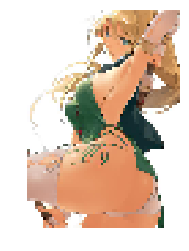

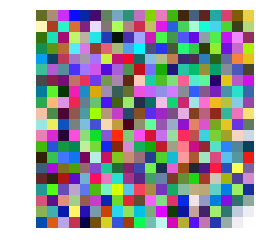

In [213]:
teachers = np.random.rand(10000, 3)

som = SOM(img_rgb, N=20,  seed=12)

# Initial map
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

# Train
som.train()

# Trained MAP
plt.imshow(som.nodes.reshape(20,20,3),
           interpolation='none')
plt.axis("off")
plt.show()

In [95]:
1086*791

859026

In [85]:
img.shape

(1086, 791, 3)

In [50]:
df.groupby(["Hue", "Saturation"])["Value"].value_counts().head()

Hue  Saturation  Value
0    0           21       229
                 58       217
                 56       197
                 19       191
                 57       178
Name: Value, dtype: int64

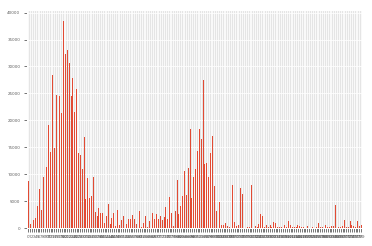

In [6]:
df["Hue"].value_counts().sort_index().plot(kind="bar", rot=0, fontsize=4)

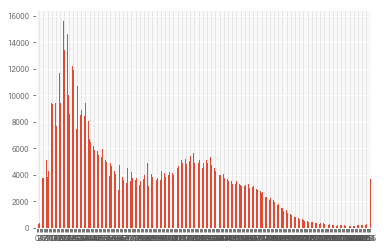

In [18]:
df["Saturation"].value_counts().sort_index().plot(kind="bar", rot=0, fontsize=7)

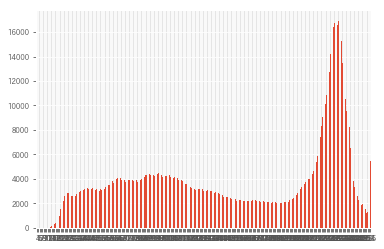

In [19]:
df["Value"].value_counts().sort_index().plot(kind="bar", rot=0, fontsize=7)

In [20]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

(-0.5, 1199.5, 799.5, -0.5)

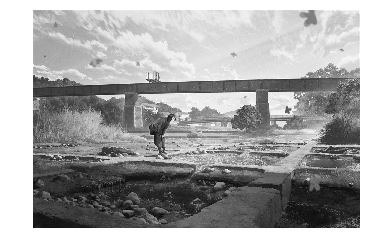

In [24]:
plt.imshow(gray_img, cmap="gray")
plt.axis("off")

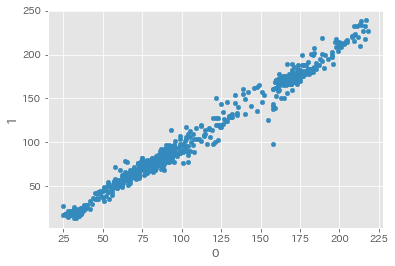

In [30]:
pd.DataFrame(gray_img).plot(kind="scatter",x=0, y=1)

meta.jsonを読み込む

In [ ]:
df = pd.read_csv("../data/download_image_monthly/20171024/meta.json", delimiter="\n", header=None)

In [ ]:
import json
meta_tags = []
#meta = json.loads(df.iloc[i].values[0])
for i in df.index:
    meta = json.loads(df.iloc[i].values[0])
    meta_tags.append(meta["tags"])

In [ ]:
meta_tags

?を置換する

In [ ]:
test = pd.read_csv("../../Automobile price data _Raw_.csv")

In [ ]:
test.replace("?", np.NaN)

In [ ]:
df=pd.DataFrame({"age": ["?", "?", "?"],
                "height": ["?", "?", "?"],
                "weight": ["?", "?", "?"]})

In [ ]:
df.replace("?", np.NaN)